In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## generate systesis data

In [2]:
!rm -r "/kaggle/working/dataset"

In [3]:
"""
Synthetic Error-Bar Plot Dataset Generator
------------------------------------------
Generates plot PNG images + JSON labels matching the provided schema:

[
  {
    "label": {"lineName": "..."},
    "points": [
      {"x": <px>, "y": <px>, "label": "", "topBarPixelDistance": <px>, "bottomBarPixelDistance": <px>, "deviationPixelDistance": <px>},
      ...
    ]
  },
  ...
]

Notes:
- (x,y) are pixel coordinates with origin at top-left (0,0).
- topBarPixelDistance = y_point - y_top_endpoint
- bottomBarPixelDistance = y_bottom_endpoint - y_point
- deviationPixelDistance in the real dataset is inconsistent; here we generate it as mostly 0,
  sometimes correlated with bar size + small noise (helps realism without assuming a wrong definition).
- Adds anchor points: ymin, ymax, xmin, xmax (with 0 distances) for each line.

Run:
  pip install numpy matplotlib
  python generate_synth_dataset.py

Output:
  dataset/
    images/<uuid>.png
    labels/<uuid>.json
"""

import os
import json
import uuid
import random
from dataclasses import dataclass
from typing import Tuple, List, Dict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# Headless backend (server-safe)
matplotlib.use("Agg")


@dataclass
class SynthConfig:
    out_root: str = "dataset"
    n_images: int = 10  # set to 2850 or 3000 when ready
    img_w: int = 960
    img_h: int = 720

    dpi_choices: Tuple[int, ...] = (120, 150, 200, 240)
    n_lines_range: Tuple[int, int] = (1, 5)
    n_points_range: Tuple[int, int] = (4, 12)

    x_mode_choices: Tuple[str, ...] = ("linear", "irregular")
    y_scale_choices: Tuple[str, ...] = ("linear", "log")

    grid_prob: float = 0.55
    legend_prob: float = 0.80
    title_prob: float = 0.35
    axis_label_prob: float = 0.85

    background_noise_prob: float = 0.35
    paper_tint_prob: float = 0.25

    capsize_choices: Tuple[float, ...] = (2.0, 3.0, 4.0, 6.0)
    elinewidth_choices: Tuple[float, ...] = (1.0, 1.2, 1.5, 2.0)
    linewidth_choices: Tuple[float, ...] = (1.0, 1.2, 1.6, 2.2)

    marker_choices: Tuple[str, ...] = ("o", "s", "^", "D", "v", "P", "X", "*", "+", "x")
    linestyle_choices: Tuple[str, ...] = ("-", "--", ":", "-.")

    # IMPORTANT: Fonts can be missing on servers; keep safe defaults.
    safe_font_choices: Tuple[str, ...] = ("DejaVu Sans", "DejaVu Serif")

    # Error size control in data units
    err_frac_range: Tuple[float, float] = (0.03, 0.20)

    # Label realism knobs
    extra_zero_points_range: Tuple[int, int] = (0, 4)   # add interpolated points with 0 distances
    deviation_nonzero_prob: float = 0.35               # fraction of points with non-zero deviation
    deviation_noise_px: float = 2.0                    # +/- noise on deviation

    # Optional: generate some twin y-axis plots (seen in real-world papers)
    dual_axis_prob: float = 0.20

    tight_layout: bool = True


def ensure_dirs(cfg: SynthConfig) -> Tuple[str, str]:
    img_dir = os.path.join(cfg.out_root, "images")
    lbl_dir = os.path.join(cfg.out_root, "labels")
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)
    return img_dir, lbl_dir


def _rand_title() -> str:
    return random.choice([
        "PK Profile",
        "Serum Concentration vs Time",
        "Dose Response",
        "Treatment Groups",
        "Study Arm A",
        "Experiment Results",
    ])


def _rand_axis_label(axis: str) -> str:
    if axis == "x":
        return random.choice(["Time (h)", "Time (days)", "Days post infusion", "Time, hours"])
    return random.choice([
        "Concentration (ng/mL)",
        "Concentration (µg/mL)",
        "Log Concentration",
        "Titer (IU/mL)",
    ])


def _sample_x(n: int, mode: str) -> np.ndarray:
    if mode == "linear":
        x = np.linspace(0, 1, n)
        x += np.random.uniform(-0.02, 0.02, size=n)
        x = np.clip(np.sort(x), 0, 1)
        return x
    return np.sort(np.random.uniform(0, 1, size=n))


def _make_y_from_x(x01: np.ndarray, y_scale: str) -> np.ndarray:
    # PK-like decay curve + noise
    base = 1.0 + 4.0 * np.exp(-3.0 * x01)
    noise = np.random.normal(0, 0.12, size=len(x01))
    y = base * (1.0 + noise)

    if y_scale == "log":
        # Map into a log-friendly range (0.05..2000)
        y = np.exp(np.interp(y, (y.min(), y.max()), (np.log(0.05), np.log(2000.0))))
        y *= np.exp(np.random.normal(0, 0.10, size=len(x01)))
        y = np.clip(y, 0.01, None)
    else:
        y = np.clip(y, 0.0, None)
    return y


def _make_err(y: np.ndarray, y_scale: str, frac_range: Tuple[float, float]) -> Tuple[np.ndarray, np.ndarray]:
    frac = np.random.uniform(frac_range[0], frac_range[1], size=len(y))
    if y_scale == "log":
        err = y * frac
    else:
        err = np.maximum(0.02 * (y.max() - y.min() + 1e-6), y * frac)

    # asymmetry
    up = err * np.random.uniform(0.7, 1.3, size=len(y))
    down = err * np.random.uniform(0.7, 1.3, size=len(y))
    return up, down


def _rgba_to_uint8(img: np.ndarray) -> np.ndarray:
    rgb = (img[..., :3] * 255.0).round().astype(np.uint8)
    return rgb


def _add_background_noise(rgb: np.ndarray, paper_tint: bool) -> np.ndarray:
    h, w, _ = rgb.shape
    out = rgb.astype(np.int16)

    if paper_tint:
        out = out + np.array([8, 6, 0], dtype=np.int16)  # warm tint

    noise = np.random.normal(0, 10, size=(h, w, 1)).astype(np.int16)
    out = out + noise

    return np.clip(out, 0, 255).astype(np.uint8)


def _fig_to_rgb_array(fig: plt.Figure) -> np.ndarray:
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape(h, w, 4)
    return _rgba_to_uint8(buf.astype(np.float32) / 255.0)


def _pixel_xy(ax, x_data: float, y_data: float, fig: plt.Figure) -> Tuple[float, float]:
    """
    Convert data coords -> image pixel coords with origin at top-left (dataset expects).
    """
    x_disp, y_disp = ax.transData.transform((x_data, y_data))  # origin bottom-left
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    return float(x_disp), float(h - y_disp)


def _make_line_name() -> str:
    if random.random() < 0.45:
        dose = random.choice([3, 10, 30, 100, 300, 1000, 1500])
        nN = random.choice([1, 3, 4, 8])
        return f"Drug_{dose}mg (N={nN})"
    return f"Line_{random.randint(1, 99)}"


def generate_one(cfg: SynthConfig, img_dir: str, lbl_dir: str, index: int) -> Tuple[str, str]:
    # Reproducible per-sample
    random.seed(index)
    np.random.seed(index)

    dpi = random.choice(cfg.dpi_choices)
    fig_w_in = cfg.img_w / dpi
    fig_h_in = cfg.img_h / dpi

    n_lines = random.randint(cfg.n_lines_range[0], cfg.n_lines_range[1])
    y_scale = random.choice(cfg.y_scale_choices)
    x_mode = random.choice(cfg.x_mode_choices)

    grid_on = random.random() < cfg.grid_prob
    show_legend = random.random() < cfg.legend_prob
    add_noise = random.random() < cfg.background_noise_prob
    paper_tint = random.random() < cfg.paper_tint_prob

    # Safe fonts only (avoid missing fonts on servers)
    plt.rcParams["font.family"] = random.choice(cfg.safe_font_choices)

    # Optional twin-axis
    use_dual_axis = (random.random() < cfg.dual_axis_prob)

    fig, ax = plt.subplots(figsize=(fig_w_in, fig_h_in), dpi=dpi)
    ax.set_yscale(y_scale)

    ax2 = None
    if use_dual_axis:
        ax2 = ax.twinx()
        # sometimes right axis is log as well, sometimes linear
        ax2.set_yscale(random.choice(cfg.y_scale_choices))

    if grid_on:
        ax.grid(True, which="both", linestyle=":", linewidth=0.8, alpha=0.7)

    if random.random() < cfg.axis_label_prob:
        ax.set_xlabel(_rand_axis_label("x"))
    if random.random() < cfg.axis_label_prob:
        ax.set_ylabel(_rand_axis_label("y"))
    if ax2 and random.random() < 0.6:
        ax2.set_ylabel(random.choice(["Log10 (Right Axis)", "Response (Right Axis)", "Secondary Metric"]))

    if random.random() < cfg.title_prob:
        ax.set_title(_rand_title())

    # Time-like x range
    x_max_unit = random.choice([48, 72, 168, 336, 42, 49])
    n_points_base = random.randint(cfg.n_points_range[0], cfg.n_points_range[1])
    x01 = _sample_x(n_points_base, x_mode)
    x_data = x01 * x_max_unit

    all_line_labels: List[Dict] = []

    for li in range(n_lines):
        keep = np.random.choice([0, 1], size=n_points_base, p=[0.15, 0.85]).astype(bool)
        if keep.sum() < 3:
            keep[np.random.choice(np.arange(n_points_base), size=3, replace=False)] = True

        x_l = x_data[keep]
        x01_l = x01[keep]

        # which axis to plot on?
        target_ax = ax2 if (ax2 is not None and random.random() < 0.35) else ax

        # for twin axis, pick y_scale based on that axis
        axis_scale = target_ax.get_yscale()
        y_l = _make_y_from_x(x01_l, axis_scale)
        up, down = _make_err(y_l, axis_scale, cfg.err_frac_range)
        yerr = np.vstack([down, up])

        marker = random.choice(cfg.marker_choices)
        ls = random.choice(cfg.linestyle_choices)
        lw = random.choice(cfg.linewidth_choices)
        capsize = random.choice(cfg.capsize_choices)
        elw = random.choice(cfg.elinewidth_choices)

        # Color randomization (not just matplotlib defaults)
        color = np.random.rand(3,)

        line_name = _make_line_name()

        target_ax.errorbar(
            x_l,
            y_l,
            yerr=yerr,
            fmt=marker,
            linestyle=ls,
            linewidth=lw,
            markersize=random.choice([4, 5, 6, 7]),
            capsize=capsize,
            elinewidth=elw,
            color=color,
            label=line_name,
        )

        # ---- Labels: always computed from LEFT axis coordinate system? ----
        # Your dataset labels are in the final rendered image pixel space, independent of axes.
        # So we compute pixel coords using the axis where the point was plotted.
        points: List[Dict] = []

        for (xd, yd, eu, ed) in zip(x_l, y_l, up, down):
            x_pix, y_pix = _pixel_xy(target_ax, float(xd), float(yd), fig)

            y_top_data = float(yd + eu)
            y_bot_data = float(yd - ed)
            
            _, y_top_pix = _pixel_xy(target_ax, float(xd), y_top_data, fig)
            _, y_bot_pix = _pixel_xy(target_ax, float(xd), y_bot_data, fig)
            
            # ---------- FIX: CLIP TO IMAGE BOUNDS ----------
            y_top_pix = float(np.clip(y_top_pix, 0, cfg.img_h))
            y_bot_pix = float(np.clip(y_bot_pix, 0, cfg.img_h))
            # ----------------------------------------------
            
            top_dist = max(0.0, y_pix - y_top_pix)
            bot_dist = max(0.0, y_bot_pix - y_pix)

            # skip insane points (twin-axis / layout artifacts)
            if not (0 <= x_pix <= cfg.img_w and 0 <= y_pix <= cfg.img_h):
                continue


            # deviationPixelDistance: mostly 0, sometimes correlated with bar size + small noise.
            if random.random() < cfg.deviation_nonzero_prob:
                dev = 0.6 * (top_dist + bot_dist) + float(np.random.uniform(-cfg.deviation_noise_px, cfg.deviation_noise_px))
                dev = max(0.0, float(dev))
            else:
                dev = 0.0

            points.append(
                {
                    "x": x_pix,
                    "y": y_pix,
                    "label": "",
                    "topBarPixelDistance": top_dist,
                    "bottomBarPixelDistance": bot_dist,
                    "deviationPixelDistance": dev,
                }
            )

        all_line_labels.append({"label": {"lineName": line_name}, "points": points})

        # Optional: extra interpolated points with zero distances (mimics real label quirks)
        extra_k = random.randint(cfg.extra_zero_points_range[0], cfg.extra_zero_points_range[1])
        if extra_k > 0 and len(x_l) >= 3:
            order = np.argsort(x_l)
            xs = x_l[order]
            ys = y_l[order]
            for _ in range(extra_k):
                ex = float(np.random.uniform(xs.min(), xs.max()))
                ey = float(np.interp(ex, xs, ys))
                ex_pix, ey_pix = _pixel_xy(target_ax, ex, ey, fig)
                all_line_labels[-1]["points"].append(
                    {
                        "x": ex_pix,
                        "y": ey_pix,
                        "label": "",
                        "topBarPixelDistance": 0,
                        "bottomBarPixelDistance": 0,
                        "deviationPixelDistance": 0,
                    }
                )

    if show_legend:
        ax.legend(
            loc=random.choice(["best", "upper right", "upper left", "lower right", "lower left"]),
            fontsize=random.choice([8, 9, 10]),
        )

    if cfg.tight_layout:
        fig.tight_layout()

    # Add anchors per line (top-left origin pixels)
    fig.canvas.draw()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    anchors = {
        "ymin": (xlim[0], ylim[0]),
        "ymax": (xlim[0], ylim[1]),
        "xmin": (xlim[0], ylim[0]),
        "xmax": (xlim[1], ylim[0]),
    }

    for line_obj in all_line_labels:
        anchor_points = []
        for lab in ["ymin", "ymax", "xmin", "xmax"]:
            xd, yd = anchors[lab]
            x_pix, y_pix = _pixel_xy(ax, float(xd), float(yd), fig)
            anchor_points.append(
                {
                    "x": x_pix,
                    "y": y_pix,
                    "label": lab,
                    "topBarPixelDistance": 0,
                    "bottomBarPixelDistance": 0,
                    "deviationPixelDistance": 0,
                }
            )
        line_obj["points"] = anchor_points + line_obj["points"]

    rgb = _fig_to_rgb_array(fig)
    if add_noise or paper_tint:
        rgb = _add_background_noise(rgb, paper_tint=paper_tint)

    file_id = str(uuid.uuid4())
    img_path = os.path.join(img_dir, f"{file_id}.png")
    lbl_path = os.path.join(lbl_dir, f"{file_id}.json")

    plt.imsave(img_path, rgb)
    with open(lbl_path, "w", encoding="utf-8") as f:
        json.dump(all_line_labels, f, ensure_ascii=False, indent=2)

    plt.close(fig)
    return img_path, lbl_path


def main():
    cfg = SynthConfig(
        out_root="dataset",
        n_images=2850,  # change to 2850 or 3000
    )
    img_dir, lbl_dir = ensure_dirs(cfg)

    print(f"Generating {cfg.n_images} synthetic plots into:")
    print(f"  {cfg.out_root}/images")
    print(f"  {cfg.out_root}/labels")

    for i in tqdm(range(cfg.n_images)):
        img_path, _ = generate_one(cfg, img_dir, lbl_dir, index=i)
        if (i + 1) % 10 == 0:
            print(f"[{i+1}/{cfg.n_images}] {os.path.basename(img_path)}")

    print("Done.")


if __name__ == "__main__":   
    main()   
 

Generating 2850 synthetic plots into:
  dataset/images
  dataset/labels


  0%|          | 0/2850 [00:00<?, ?it/s]

[10/2850] 7d4e6045-8a7c-43bd-b950-57d9d3ded353.png
[20/2850] 52d95aa3-c8a8-4bfb-a18f-3b787b2e5ed4.png


/tmp/ipykernel_55/619238117.py:374: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


[30/2850] 158cbcf8-e6ad-4d06-99d4-5bc7fade582e.png
[40/2850] 63b93240-cf57-491f-bf87-462b5e264cea.png
[50/2850] e69e2a2c-0af8-48ab-9739-132f8367a8e2.png
[60/2850] 73be0c14-1c21-44c0-80b6-8440dbdded1a.png
[70/2850] 130e7591-a029-450e-9d28-00ecd54071ab.png
[80/2850] 10a2f95f-4335-44cf-9d4e-db39aef04ba8.png
[90/2850] ae8abe4f-d842-4b4d-a888-d760e04ccc88.png
[100/2850] 7d5204f8-32a1-4911-9d37-8e4f34494500.png
[110/2850] b4d9d548-3e8c-48cd-a110-0f1303ec17db.png
[120/2850] a5bc14da-fdba-42b4-ab13-e5feeda31a33.png
[130/2850] 5085099e-7b7d-47d7-9600-3b1e157727ef.png
[140/2850] a5a4aaca-aaf8-4157-bac7-1b3bb7df64ea.png
[150/2850] 4cf04151-61e0-48c6-be05-1003863f2df3.png
[160/2850] 693c8de9-e9a9-4ffc-b45f-bfb3ba96a162.png
[170/2850] 53fb1f00-daa5-4c2c-8910-cc2591c5963c.png
[180/2850] f0b9a1c6-3c64-44c8-8d54-45c6a2f2dd7c.png
[190/2850] 9df9226d-c0b0-40aa-80c2-a87797a2af74.png
[200/2850] 5b78ab36-a982-4120-b004-20ffe9deca95.png
[210/2850] 1acc2cc2-66cc-4677-8ea5-8c4062797fc2.png
[220/2850] 742d08dd

## visualizing generated data

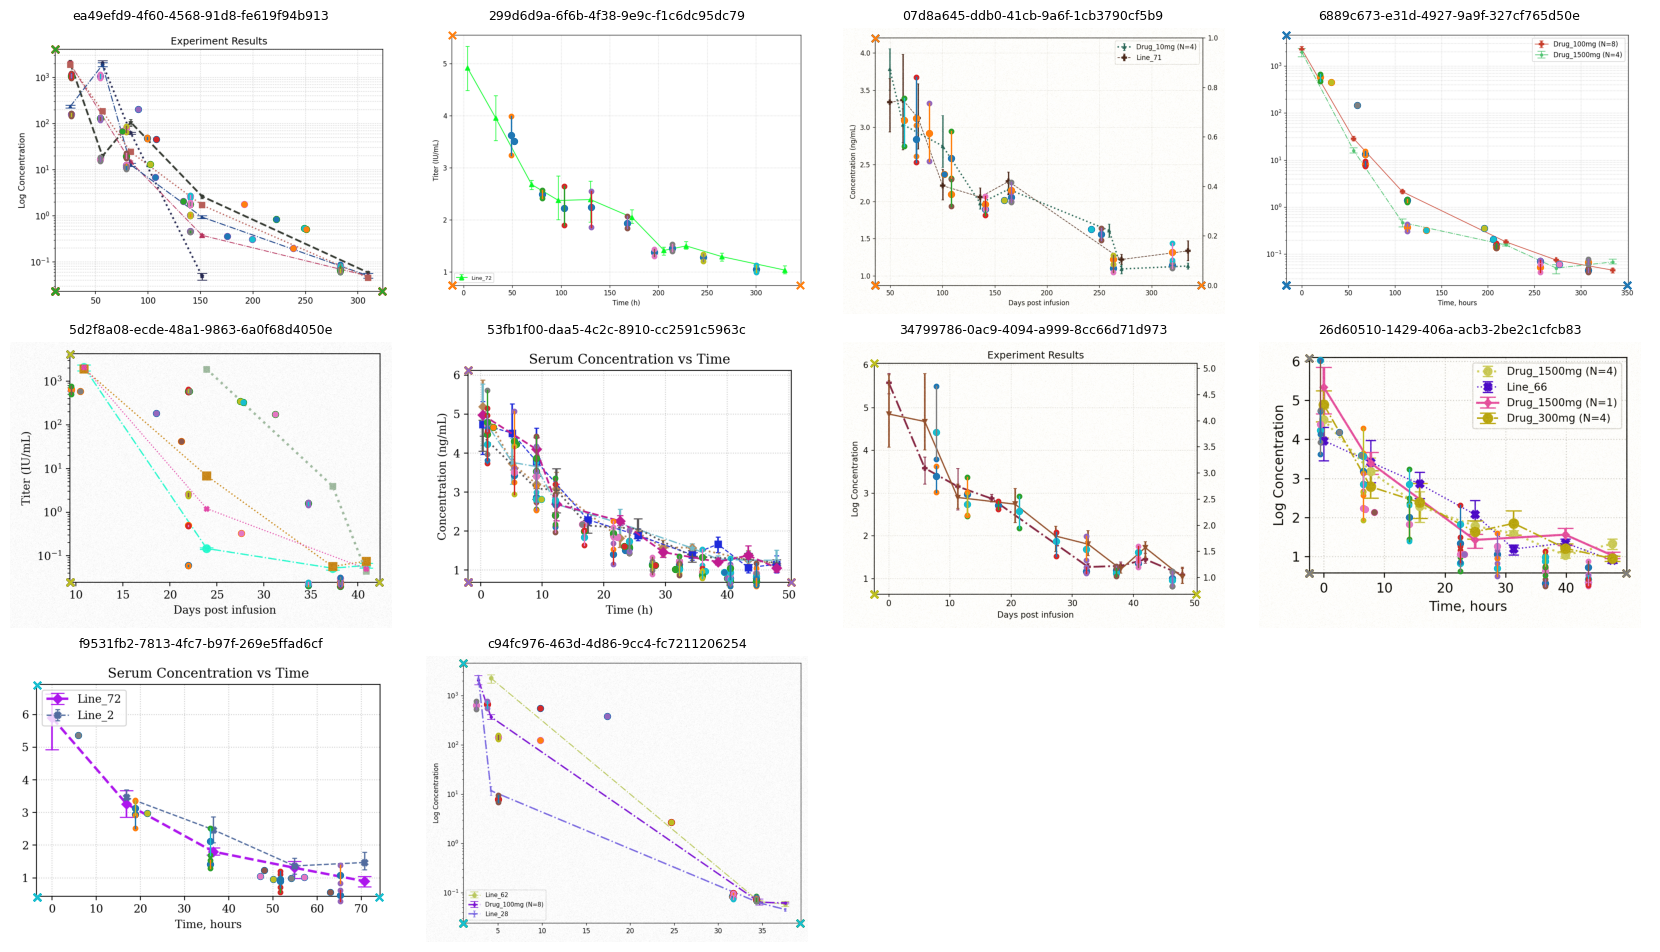

In [5]:
%matplotlib inline


import os, json, random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

DATASET_ROOT = "/kaggle/working/dataset"   
N_SAMPLES = 10
SEED = 42

img_dir = Path(DATASET_ROOT) / "images"
lbl_dir = Path(DATASET_ROOT) / "labels"

imgs = sorted(list(img_dir.glob("*.png")))
assert len(imgs) > 0, f"No images found in {img_dir}"

random.seed(SEED)
picked = random.sample(imgs, k=min(N_SAMPLES, len(imgs)))

def load_label(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def overlay(ax, img, label_data, title=""):
    h, w = img.shape[0], img.shape[1]
    ax.imshow(img)
    ax.set_title(title, fontsize=9)
    ax.set_xlim(0, w)
    ax.set_ylim(h, 0)  # top-left origin like your dataset

    for line in label_data:
        line_name = line.get("label", {}).get("lineName", "line")
        pts = line.get("points", [])

        # collect points for one scatter call
        xs, ys = [], []
        ax_xs, ax_ys = [], []  # anchors
        stems = []             # list of (x, y_top, y_bot)

        for p in pts:
            x = float(p.get("x", 0))
            y = float(p.get("y", 0))
            lab = (p.get("label") or "").strip()

            # skip far-out junk for display
            if not (-50 <= x <= w + 50 and -50 <= y <= h + 50):
                continue

            if lab in {"xmin", "xmax", "ymin", "ymax"}:
                ax_xs.append(x); ax_ys.append(y)
                continue

            t = float(p.get("topBarPixelDistance", 0) or 0)
            b = float(p.get("bottomBarPixelDistance", 0) or 0)

            xs.append(x); ys.append(y)
            stems.append((x, y - t, y + b))

        if xs:
            ax.scatter(xs, ys, s=18, label=line_name)

        # draw stems + endpoints
        for x, y_top, y_bot in stems:
            ax.plot([x, x], [y_top, y_bot], linewidth=1)
            ax.scatter([x, x], [y_top, y_bot], s=10)

        if ax_xs:
            ax.scatter(ax_xs, ax_ys, s=28, marker="x")

    ax.axis("off")

cols = 4
rows = (len(picked) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(4.2*cols, 3.2*rows))
axes = np.array(axes).reshape(rows, cols)

for i, img_path in enumerate(picked):
    r, c = divmod(i, cols)
    base = img_path.stem
    label_path = lbl_dir / f"{base}.json"

    img = mpimg.imread(img_path)
    if label_path.exists():
        label_data = load_label(label_path)
        overlay(axes[r, c], img, label_data, title=base)
    else:
        axes[r, c].imshow(img)
        axes[r, c].set_title(f"{base} (missing label)", fontsize=9)
        axes[r, c].axis("off")

# turn off unused
for j in range(len(picked), rows*cols):
    r, c = divmod(j, cols)
    axes[r, c].axis("off")

plt.tight_layout()
plt.show()


## dataset_sanity_stats

In [6]:
def dataset_sanity_stats(dataset_root):
    img_dir = Path(dataset_root) / "images"
    lbl_dir = Path(dataset_root) / "labels"

    imgs = sorted(list(img_dir.glob("*.png")))
    oob = 0
    total = 0
    missing = 0

    for img_path in imgs:
        base = img_path.stem
        label_path = lbl_dir / f"{base}.json"
        if not label_path.exists():
            missing += 1
            continue

        img = mpimg.imread(img_path)
        h, w = img.shape[0], img.shape[1]
        data = load_label(label_path)

        for line in data:
            for p in line.get("points", []):
                lab = (p.get("label") or "").strip()
                if lab in {"xmin", "xmax", "ymin", "ymax"}:
                    continue
                x = float(p.get("x", 0))
                y = float(p.get("y", 0))
                total += 1
                if not (0 <= x <= w and 0 <= y <= h):
                    oob += 1

    print(f"Images: {len(imgs)}")
    print(f"Missing labels: {missing}")
    print(f"Total non-anchor points: {total}")
    print(f"Out-of-bounds points: {oob} ({(oob/total*100 if total else 0):.2f}%)")

dataset_sanity_stats(DATASET_ROOT)


Images: 2850
Missing labels: 0
Total non-anchor points: 72523
Out-of-bounds points: 0 (0.00%)


## pixes distribution

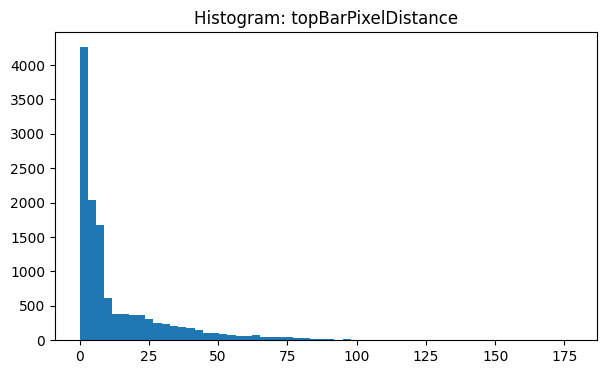

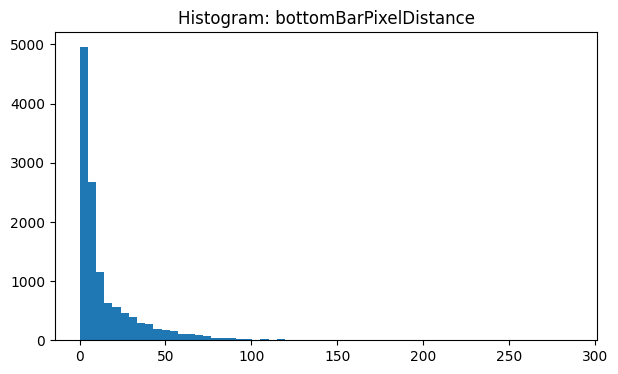

top: min/median/max = 0.0 5.989902920621489 177.968056188209
bot: min/median/max = 0.0 6.99261315626444 286.926970339297


In [7]:
tops = []
bots = []

for img_path in imgs[:min(500, len(imgs))]:  # sample first 500 for speed
    base = img_path.stem
    label_path = lbl_dir / f"{base}.json"
    if not label_path.exists():
        continue
    data = load_label(label_path)
    for line in data:
        for p in line.get("points", []):
            lab = (p.get("label") or "").strip()
            if lab in {"xmin", "xmax", "ymin", "ymax"}:
                continue
            tops.append(float(p.get("topBarPixelDistance", 0) or 0))
            bots.append(float(p.get("bottomBarPixelDistance", 0) or 0))

plt.figure(figsize=(7,4))
plt.hist(tops, bins=60)
plt.title("Histogram: topBarPixelDistance")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(bots, bins=60)
plt.title("Histogram: bottomBarPixelDistance")
plt.show()

print("top: min/median/max =", np.min(tops), np.median(tops), np.max(tops))
print("bot: min/median/max =", np.min(bots), np.median(bots), np.max(bots))


In [16]:
!zip -r "synthetic_data.zip" "/kaggle/working/dataset"

  adding: kaggle/working/dataset/ (stored 0%)
  adding: kaggle/working/dataset/labels/ (stored 0%)
  adding: kaggle/working/dataset/labels/d0908b9b-a853-4ec1-9a1a-a266af555979.json (deflated 85%)
  adding: kaggle/working/dataset/labels/03d91acc-cddd-4d63-84c3-83ed1c7bd9c1.json (deflated 87%)
  adding: kaggle/working/dataset/labels/f129402e-e114-43b4-8572-fc6f1b8fe917.json (deflated 86%)
  adding: kaggle/working/dataset/labels/9d7658ca-52ed-4712-bb4b-e93d8c01aebd.json (deflated 86%)
  adding: kaggle/working/dataset/labels/c53e3416-b2b2-4614-9da0-17416cc8d39d.json (deflated 87%)
  adding: kaggle/working/dataset/labels/50f58ecd-cf8f-4698-a1fa-e5dc3709df99.json (deflated 85%)
  adding: kaggle/working/dataset/labels/0df1488a-a35e-49da-a464-4fd1d874019a.json (deflated 80%)
  adding: kaggle/working/dataset/labels/8d0a06dc-3b31-4dc6-8453-4949268e63ff.json (deflated 86%)
  adding: kaggle/working/dataset/labels/6684a8c9-4fd6-4cd6-8577-50f6ec71c530.json (deflated 81%)
  adding: kaggle/working/dat

In [17]:
from IPython.display import FileLink
FileLink('synthetic_data.zip')

/kaggle/working/synthetic_data.zip